In [1]:
# dependencies
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import h5py
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm 
import scipy.stats as st
from scipy.stats import zscore
import numpy.random as npr
import ssm
import seaborn as sns
from ssm.util import one_hot, find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap
from datetime import date

from postProcessing import * #my module
from plottingfunctions import * #my module
from commonFunctions import * #my module

#to add to filenames as datestring
today = date.today()
datestring = today.strftime("%m%d%y")

npr.seed(0)

sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "maroon",
    "slate",
    "light violet",
    "golden yellow",
    "bright pink",
    "bright turquoise"
    ]

genotype_colors = sns.xkcd_palette(color_names)

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

sns.set(palette="colorblind")
default_colors = sns.color_palette("colorblind")

# sns.set(palette="bright")
# default_colors = sns.color_palette("bright")


# Speficy whether or not to save figures
saveFigures = True

#load style params
#locate data directory
dataDir = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/LAWNLEAVINGPROCESSEDDATA/ssm/notebooks'
figpath = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/MANUSCRIPT/figures/checkScriptVersion/Figure1'
plt.style.use(os.path.join(dataDir,'../styleparams/presentation_smallerfonts.mplstyle'))


#used for all new data loaded in
binSize = 30
minFillLen = binSize

In [2]:
#load or save pre-processed WILDTYPE data (one Pickle for all Data now)
import pickle
#save and load binned data for mutants
#import 10 sec binned data and pca

processDataPath = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/LAWNLEAVINGPROCESSEDDATA/MATFILEDATA/Pickles'

with open(os.path.join(processDataPath,'PD1074_od2_Fig1_021523.pkl'),'rb') as f:  # Python 3: open(..., 'rb')
    bins,binSize,wildtype = pickle.load(f)
    

In [3]:
Data = wildtype['PD1074_od2_Data']
genotypes = 'wild type'

In [4]:
Data['videoname'].shape

(1443, 1)

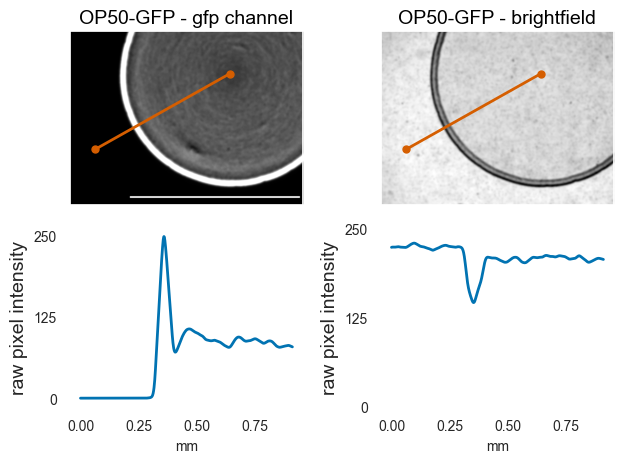

In [5]:
#check out bacterial food spatial distribution with OP50-GFP

import glob
import skimage
from skimage import io
import scipy.ndimage
from scipy.spatial.distance import cdist

images_filepath = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/OP50GFP/OD 2.0/undisturbed/'
subfolders = glob.glob(os.path.join(images_filepath,"*/"))


#load in brightfield image and gfp image
dir_index = 2
directory_contents = os.listdir(subfolders[dir_index])
#in these directories, c3 means gfp, c6 means brightfield
gfp_file = os.path.join(subfolders[dir_index],\
                        directory_contents[np.where(['_gfp' in name for name in directory_contents])[0][0]])
bf_file = os.path.join(subfolders[dir_index],\
                       directory_contents[np.where(['_bf' in name for name in directory_contents])[0][0]])
# gfp_file = os.path.join(subfolders[dir_index],\
#                         directory_contents[np.where(['c3' in name for name in directory_contents])[0][0]])
# bf_file = os.path.join(subfolders[dir_index],\
#                        directory_contents[np.where(['c6' in name for name in directory_contents])[0][0]])

bf = io.imread(bf_file)
gfp = io.imread(gfp_file)

pixelsize = 1e-3 #in mm (read manually from FIJI Image...Properties, 1 micron pixel size)

#make an object for drawing lines on plots
class LineDrawer(object):
    lines = []
    def draw_line(self,ax):
        xy = plt.ginput(2)

        x = [p[0] for p in xy]
        y = [p[1] for p in xy]
        line = plt.plot(x,y)
        ax.figure.canvas.draw()
        self.lines.append(line)
        return x,y
    
#draw a transect for profiling
%matplotlib tk
import matplotlib.pyplot as plt
fig,axs = plt.subplots(1,1,figsize=(5,5))
axs.imshow(gfp,cmap="gray")
axs.grid(b=None)
ld = LineDrawer()
x_raw,y_raw = ld.draw_line(axs)

plt.close(fig)

#Extract the line and plot the profile
%matplotlib inline
import matplotlib.pyplot as plt
# Make a line with "num" points...
x0, y0 = x_raw[0], y_raw[0] # These are in _pixel_ coordinates!!
x1, y1 = x_raw[1], y_raw[1]
num = 1000
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
lineseg_length = cdist(np.array([[x0,y0]]), np.array([[x1,y1]]), 'euclidean')[0][0]*pixelsize


# Extract the values along the line, using cubic interpolation
window = 40
gfp_profile = movMean(scipy.ndimage.map_coordinates(gfp, np.vstack((x,y))),window)[window:-window]
bf_profile = movMean(scipy.ndimage.map_coordinates(bf, np.vstack((x,y))),window)[window:-window]
dist_vector = np.linspace(0,lineseg_length,gfp_profile.shape[0])

#-- Plot...
fig, axes = plt.subplots(nrows=2,ncols=2)
axes[0][0].imshow(gfp,cmap='gray')
axes[0][0].grid(b=None)
axes[0][0].plot([x0, x1], [y0, y1], 'ro-',markersize=5)
axes[0][0].axis('image')
axes[0][0].set_xticks([])
axes[0][0].set_yticks([])
axes[0][0].set_title('OP50-GFP - gfp channel',fontsize=14)

axes[1][0].set_facecolor('w')
axes[1][0].grid(b=None)
axes[1][0].plot(dist_vector,gfp_profile)
# axes[1][0].set_xticks([])
axes[1][0].set_xlabel("mm")
axes[1][0].set_yticks(np.linspace(0,250,3))
axes[1][0].set_ylabel('raw pixel intensity',fontsize=14)

axes[0][1].imshow(bf,cmap='gray')
axes[0][1].grid(b=None)
axes[0][1].plot([x0, x1], [y0, y1], 'ro-',markersize=5)
axes[0][1].axis('image')
axes[0][1].set_xticks([])
axes[0][1].set_yticks([])
axes[0][1].set_title('OP50-GFP - brightfield',fontsize=14)

axes[1][1].set_facecolor('w')
axes[1][1].grid(b=None)
axes[1][1].plot(dist_vector,bf_profile)
axes[1][1].set_xlabel("mm")
# axes[1][1].set_xticks([])
axes[1][1].set_yticks(np.linspace(0,250,3))
axes[1][1].set_ylabel('raw pixel intensity',fontsize=14)

outpath = os.path.join(figpath,'OP50_gfp_bf_transectprofile'+'_'+datestring+'.pdf')
plt.savefig(outpath)#,dpi=300)

### A. Description: Lawn features, head poke types, lawn exits


In [6]:
#fraction outside the boundary
feature1 = Data['bin_Lawn_Boundary_Dist']
print(np.mean(feature1.ravel()<=0))
#fraction within 0.5 mm inside the boundary
print(np.mean(np.logical_and(feature1.ravel()>0,feature1.ravel()<=0.5)))
#fraction greater than 0.5 mm inside the boundary
print(np.mean(feature1.ravel()>0.5))

0.03132074382074382
0.7116279741279742
0.24582755832755832


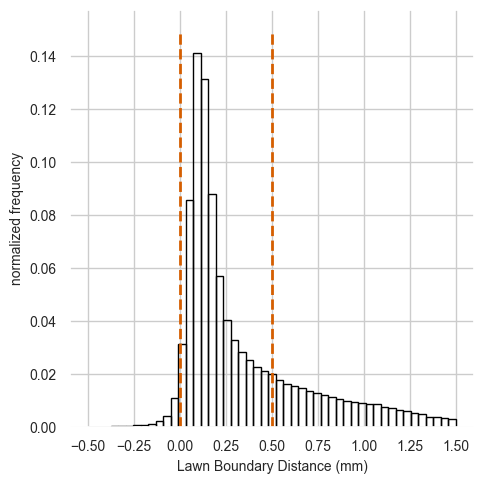

In [7]:
# Lawn Boundary Distance distribution
feature1Label = 'Lawn Boundary Distance (mm)'
feature1 = Data['bin_Lawn_Boundary_Dist']
feature1dataRange = np.linspace(-0.5,1.5,50)

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
faceColor = (0.5, 0.5, 0.5, 0)
colorForEdge = 'black'
lineWeight = 1

BinNumel = len(feature1.ravel())
_ = axs.hist(feature1.ravel(), bins=np.linspace(feature1dataRange[0], feature1dataRange[-1], 50), fc=faceColor,
                edgecolor=colorForEdge, lw=lineWeight, weights=np.ones(BinNumel) / BinNumel)
_ = axs.vlines(0,0,0.15,colors='r',linestyles='dashed')
_ = axs.vlines(0.5,0,0.15,colors='r',linestyles='dashed')
_ = axs.set_xlabel(feature1Label)
_ = axs.set_ylabel('normalized frequency')

if saveFigures:
    outpath = os.path.join(figpath,'LawnBoundaryDistance_'+datestring+'.pdf')
    plt.savefig(outpath)

In [8]:
#fraction of animals that do one:
frac_animals_doing_LL = np.sum(np.nansum(Data['Lawn_Exit'],axis=1)>0)/Data['Lawn_Exit'].shape[0]
frac_animals_doing_HPR = np.sum(np.nansum(Data['HeadPokeRev'],axis=1)>0)/Data['HeadPokeRev'].shape[0]
frac_animals_doing_HPF = np.sum(np.nansum(Data['HeadPokeFwd'],axis=1)>0)/Data['HeadPokeFwd'].shape[0]
frac_animals_doing_HPP = np.sum(np.nansum(Data['HeadPokePause'],axis=1)>0)/Data['HeadPokePause'].shape[0]
#fraction of headpokes of each type
allHPs = np.logical_or(np.logical_or(Data['HeadPokeRev'],Data['HeadPokeFwd']),Data['HeadPokePause'])
np.sum(np.sum(Data['HeadPokeRev']))/np.sum(np.sum(allHPs))

0.7317604938838271

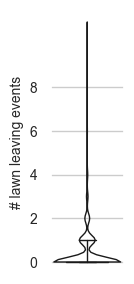

In [11]:
#Plot out just # of lawn leaving events per assay
LLperAssay = np.sum(Data['Lawn_Exit'],axis=1)
BehavFreq = pd.DataFrame(data={'lawn leaving events':LLperAssay})
fig,axs = plt.subplots(1,1,figsize=(1.5,3))

#then overlay a violinplot, outline only
g = sns.violinplot(ax = axs, data=BehavFreq,dodge=True, linewidth=1,cut=0,color='k',saturation = 1,inner=None,scale='width',zorder=0)
for violin in g.collections:
    violin.set_edgecolor(violin.get_facecolor())
    violin.set_facecolor('None')

#DIY custom boxplot
#make the medians pop, plot the quartiles a bit narrower
m_width = 0.5
q_width = 0.2
medians = BehavFreq.median()
lower_q = BehavFreq.quantile(0.25)
upper_q = BehavFreq.quantile(0.75)

for i, xtick in enumerate(g.get_xticks()):
    g.plot([xtick-q_width/2, xtick+q_width/2], [lower_q[i], lower_q[i]], color= 'k', linestyle='-', linewidth=1,zorder=3)
    g.plot([xtick-q_width/2, xtick+q_width/2], [upper_q[i], upper_q[i]], color= 'k', linestyle='-', linewidth=1,zorder=3)
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians[i], medians[i]], color= 'k', linestyle='-', linewidth=1,zorder=3)
    g.plot([xtick, xtick], [lower_q[i], upper_q[i]], color= 'k', linestyle='-', linewidth=1,zorder=3)
    
g.set_yticks(np.arange(0,10,2))
g.set_xticklabels([None], rotation=45,ha='right')
g.set_ylabel('# lawn leaving events')

if saveFigures:
    outpath = os.path.join(figpath,'NumLLEventsPerAnimal'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#dpi=300)

In [12]:
genotypes = ["wild type"]

In [14]:
figsize = (9,3)

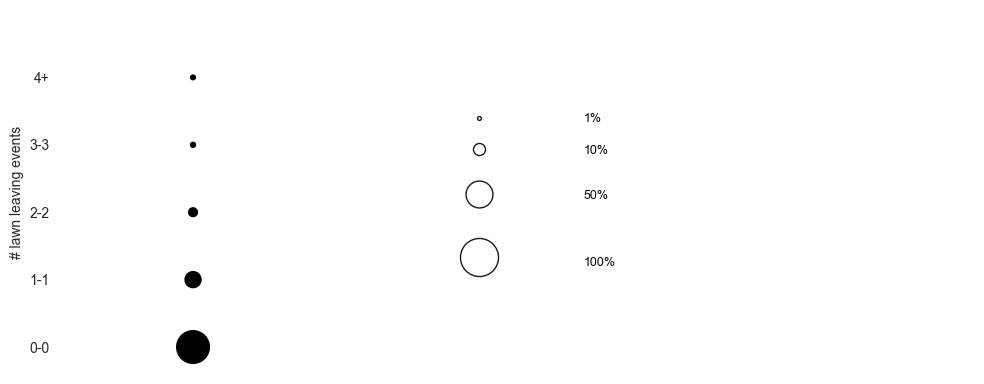

In [15]:
# Assign each animal to a bin of number of lawn leaving events
bins = np.array([-0.02,0.5,1.5,2.5,3.5,np.inf])#low range
out,outbins = pd.cut(LLperAssay,bins,retbins=True)
LL_df = pd.DataFrame(data={"genotype":np.repeat("wild type",len(out)),"numLLevent_bin":out})
tmp = LL_df.groupby(["numLLevent_bin"]).agg("count").T.to_numpy()
FracNumLLcountsPerBin = tmp/np.sum(tmp)

fig,axs = plt.subplots(1,1,figsize=(figsize[0]+1,figsize[1]+1))
axs.grid(b=None)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

rad = 750
yscalefactor = 0.75

axs.scatter(np.repeat(i,len(outbins)-1), np.arange(len(outbins)-1)*yscalefactor, s=FracNumLLcountsPerBin*rad, c = 'black', alpha=1)

axs.scatter(len(genotypes)+0.1,len(outbins)-3.45,s=0.01*rad,c='white',edgecolors='k',lw=1)
axs.text(len(genotypes)+0.5,len(outbins)-3.5,'1%',fontsize=9)
axs.scatter(len(genotypes)+0.1,len(outbins)-3.8,s=0.10*rad,c='white',edgecolors='k',lw=1)
axs.text(len(genotypes)+0.5,len(outbins)-3.85,'10%',fontsize=9)
axs.scatter(len(genotypes)+0.1,len(outbins)-4.3,s=0.50*rad,c='white',edgecolors='k',lw=1)
axs.text(len(genotypes)+0.5,len(outbins)-4.35,'50%',fontsize=9)
axs.scatter(len(genotypes)+0.1,len(outbins)-5,s=1*rad,c='white',edgecolors='k',lw=1)
axs.text(len(genotypes)+0.5,len(outbins)-5.1,'100%',fontsize=9)

axs.set_xlim(-0.5,len(genotypes)+2)
axs.set_ylim(-0.3,(len(outbins)-1)*yscalefactor)
axs.set_yticks(np.arange(len(outbins)-1)*yscalefactor)
leftColumn = np.concatenate(([0],outbins[1:-1]+1)).reshape(-1,1)
rightColumn = outbins[1:].reshape(-1,1)
together = np.hstack((leftColumn,rightColumn)).astype(int)
yTickLabels = [str(t[0])+'-'+str(t[1]) for t in together]
yTickLabels[-1] = str(leftColumn[-1][0].astype(int))+'+'
axs.set_yticklabels(yTickLabels,fontsize=10)
axs.set_ylabel('# lawn leaving events')
axs.set_xticks([0])
axs.set_xticklabels([''],rotation=45,ha='right')


if saveFigures:
    outpath = os.path.join(figpath,'NumLLEventsPerAnimal_BubblePlot'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#dpi=300)


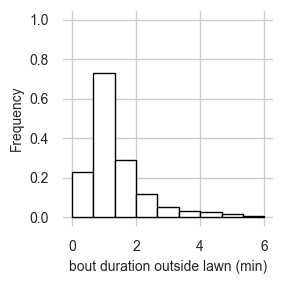

In [16]:
#compare Out Duration Distributions across genotypes
_, ax = plt.subplots(1, 1, figsize=(3, 3))
outDurBins = np.linspace(0,6,10)

outDurations = getOutLawnDurations(Data,40*6,40*6)
colorForEdge = 'black'
faceColor = "white"
BinNumel = outDurations.shape[0]
ax.hist(outDurations[:,2]/6,bins=outDurBins,density=True,alpha=1,lw=1,fc=faceColor,
                edgecolor=colorForEdge, weights=np.ones(BinNumel) / BinNumel)
# ax.hist(outDurations[:,2]/6,bins=outDurBins,density=True,linestyle='solid',alpha=1,histtype='step',cumulative=-1,lw=2.5,color=genotype_colors[0])

ax.set_ylim(-0.05,1.05)
ax.set_xlabel('bout duration outside lawn (min)')
ax.set_ylabel('Frequency')

if saveFigures:
    outpath = os.path.join(figpath,'DurationOutsideBoutsDist'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#dpi=300)


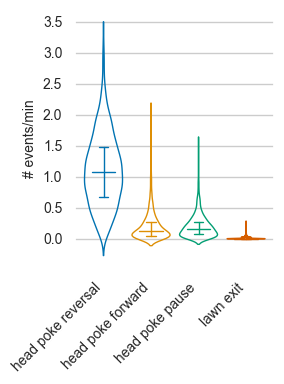

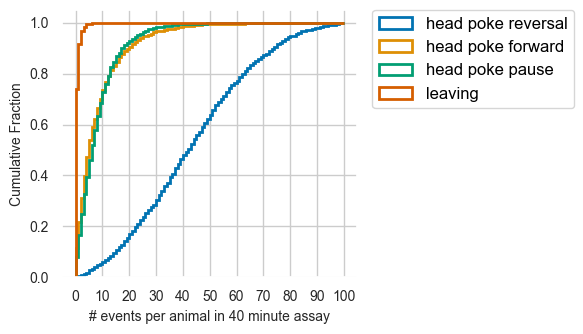

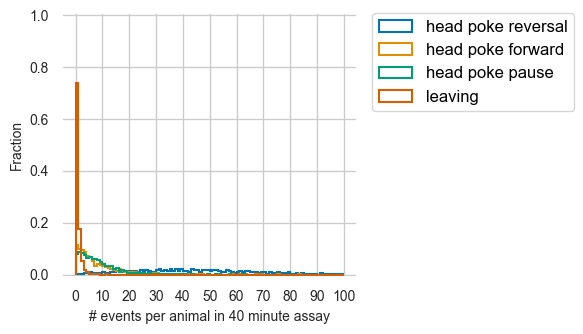

In [17]:
#Compare the frequency per min of various lawn-interaction behaviors
LLperMin = np.sum(Data['Lawn_Exit'],axis=1)/40
HPRperMin = np.sum(Data['HeadPokeRev'],axis=1)/40
HPFperMin = np.sum(Data['HeadPokeFwd'],axis=1)/40
HPPperMin = np.sum(Data['HeadPokePause'],axis=1)/40

BehavFreq = pd.DataFrame(data={'head poke reversal':HPRperMin,'head poke forward':HPFperMin,'head poke pause':HPPperMin,'lawn exit':LLperMin})
# BehavFreq = pd.DataFrame(data={'head poke reversal':HPRperMin,'lawn exit':LLperMin})

fig,axs = plt.subplots(1,1,figsize=(3,4))
# g = sns.stripplot(data=BehavFreq,jitter=True,dodge=True, linewidth=1,edgecolor='None',size=2,ax=axs,zorder=0)
# sns.boxplot(data=BehavFreq,showfliers=False,ax=g,zorder=1)

#then overlay a violinplot, outline only
g = sns.violinplot(ax = axs, data=BehavFreq,dodge=True, linewidth=1,palette=default_colors,saturation = 1,inner=None,scale='width',zorder=0)
for violin in g.collections:
    violin.set_edgecolor(violin.get_facecolor())
    violin.set_facecolor('None')

#DIY custom boxplot
#make the medians pop, plot the quartiles a bit narrower
m_width = 0.5
q_width = 0.2
medians = BehavFreq.median()
lower_q = BehavFreq.quantile(0.25)
upper_q = BehavFreq.quantile(0.75)

for i, xtick in enumerate(g.get_xticks()):
    g.plot([xtick-q_width/2, xtick+q_width/2], [lower_q[i], lower_q[i]], color= default_colors[i], linestyle='-', linewidth=1,zorder=3)
    g.plot([xtick-q_width/2, xtick+q_width/2], [upper_q[i], upper_q[i]], color= default_colors[i], linestyle='-', linewidth=1,zorder=3)
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians[i], medians[i]], color= default_colors[i], linestyle='-', linewidth=1,zorder=3)
    g.plot([xtick, xtick], [lower_q[i], upper_q[i]], color= default_colors[i], linestyle='-', linewidth=1,zorder=3)
    

g.set_xticklabels(g.get_xticklabels(), rotation=45,ha='right')
# g.set_yscale('log',base=2)
# g.set_xticklabels(['head poke reversal','leaving'], rotation=45,ha='right')
g.set_ylabel('# events/min')

if saveFigures:
    outpath = os.path.join(figpath,'LawnBoundaryBehaviorFrequency'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#dpi=300)
    
#OR as cumulative fraction of events per animal
LLperanimal = np.sum(Data['Lawn_Exit'],axis=1)
HPRperanimal = np.sum(Data['HeadPokeRev'],axis=1)
HPFperanimal = np.sum(Data['HeadPokeFwd'],axis=1)
HPPperanimal = np.sum(Data['HeadPokePause'],axis=1)

fig,axs = plt.subplots(1, 1, sharey=True, tight_layout=True, figsize=(6,3.5))
bignum = 101
leavingBins = np.arange(0,bignum,1)
tickspots = np.arange(0,bignum,10)
ticklabels= np.round(tickspots).astype(int).astype(str)

axs.hist(HPRperanimal,bins=leavingBins,density=True, color=default_colors[0],linestyle='solid',alpha=1,histtype='step',cumulative=True,lw=2,label='head poke reversal')
axs.hist(HPFperanimal,bins=leavingBins,density=True,color=default_colors[1],linestyle='solid',alpha=1,histtype='step',cumulative=True,lw=2,label='head poke forward')
axs.hist(HPPperanimal,bins=leavingBins,density=True,color=default_colors[2],linestyle='solid',alpha=1,histtype='step',cumulative=True,lw=2,label='head poke pause')
axs.hist(LLperanimal,bins=leavingBins,density=True,color=default_colors[3],linestyle='solid',alpha=1,histtype='step',cumulative=True,lw=2,label='leaving')

fix_hist_step_vertical_line_at_end(axs)
axs.set_xticks(ticks=tickspots)
axs.set_xticklabels(ticklabels)
axs.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
axs.set_xlabel('# events per animal in 40 minute assay')
axs.set_ylabel('Cumulative Fraction')

if saveFigures:
    outpath = os.path.join(figpath,'LawnBoundaryBehaviorCumFrac'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#dpi=300)

fig,axs = plt.subplots(1, 1, sharey=True, tight_layout=True, figsize=(6,3.5))
bignum = 101
leavingBins = np.arange(0,bignum,1)
tickspots = np.arange(0,bignum,10)
ticklabels= np.round(tickspots).astype(int).astype(str)

axs.hist(HPRperanimal,bins=leavingBins,density=True, color=default_colors[0],linestyle='solid',alpha=1,histtype='step',cumulative=False,lw=1.5,label='head poke reversal')
axs.hist(HPFperanimal,bins=leavingBins,density=True,color=default_colors[1],linestyle='solid',alpha=1,histtype='step',cumulative=False,lw=1.5,label='head poke forward')
axs.hist(HPPperanimal,bins=leavingBins,density=True,color=default_colors[2],linestyle='solid',alpha=1,histtype='step',cumulative=False,lw=1.5,label='head poke pause')
axs.hist(LLperanimal,bins=leavingBins,density=True,color=default_colors[3],linestyle='solid',alpha=1,histtype='step',cumulative=False,lw=1.5,label='leaving')

fix_hist_step_vertical_line_at_end(axs)
axs.set_xticks(ticks=tickspots)
axs.set_xticklabels(ticklabels)
axs.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
axs.set_xlabel('# events per animal in 40 minute assay')
axs.set_ylabel('Fraction')
axs.set_ylim(-0.01,1.01)

if saveFigures:
    outpath = os.path.join(figpath,'LawnBoundaryBehaviorHistFrac'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#dpi=300)

In [ ]:
#Raw Midbody speed (unbinned)

#set parameters for aligning things
framesPerMin = 180
numMins = 1
missingFracThresh = 0.7 #for displaying averages
binTimeBefore = numMins*framesPerMin
binTimeAfter = binTimeBefore
maskToUse = np.zeros_like(Data['Lawn_Boundary_Dist']).astype(bool)

Speed_HPFWD_aligned, Mask_aligned, binTimeLine, binAlignIdx = alignData_masked(
            Data['Midbody_speed'], maskToUse, Data['HeadPokeFwd'],
            binTimeBefore, binTimeAfter, dtype=float)

Speed_HPREV_aligned, Mask_aligned, binTimeLine, binAlignIdx = alignData_masked(
            Data['Midbody_speed'], maskToUse, Data['HeadPokeRev'],
            binTimeBefore, binTimeAfter, dtype=float)

Speed_HPPAUSE_aligned, Mask_aligned, binTimeLine, binAlignIdx = alignData_masked(
            Data['Midbody_speed'], maskToUse, Data['HeadPokePause'],
            binTimeBefore, binTimeAfter, dtype=float)

Speed_LawnExit_aligned, Mask_aligned, binTimeLine, binAlignIdx = alignData_masked(
            Data['Midbody_speed'], maskToUse, Data['Lawn_Exit'],
            binTimeBefore, binTimeAfter, dtype=float)




In [ ]:
#plot Raw Midbody speed aligned
timeLine2 = binTimeLine / framesPerMin

# xticksToPlot = np.hstack((binTimeLine[0:-1:framesPerMin], binTimeLine[-1])) #every minute ticks
# xtickLabels = np.round((xticksToPlot / framesPerMin)).astype(int)
# xticksToPlot2 = np.round(np.linspace(timeLine2[0], timeLine2[-1], len(xticksToPlot)))

xticksToPlot = np.hstack((binTimeLine[0:-1:int(framesPerMin/2)], binTimeLine[-1])) #every 30 seconds ticks
xtickLabels = np.round((xticksToPlot / framesPerMin),1)
xticksToPlot2 = np.round(np.linspace(timeLine2[0], timeLine2[-1], len(xticksToPlot)),1)


_, ax = plt.subplots(1, 1, figsize=(6, 4))
ax = plotMeanSEMCurve(ax,Speed_HPREV_aligned,missingFracThresh,'head poke reversal',binTimeLine,framesPerMin,default_colors[0])
# ax = plotMeanSEMCurve(ax,Speed_LawnExit_aligned,1,'leaving',binTimeLine,framesPerMin,default_colors[3])
ax = plotMeanSEMCurve(ax,Speed_LawnExit_aligned[:,0:binTimeBefore+1],1,'leaving',binTimeLine[0:binTimeBefore+1],framesPerMin,default_colors[3])

ax = plotMeanSEMCurve(ax,Speed_HPFWD_aligned,missingFracThresh,'head poke forward',binTimeLine,framesPerMin,default_colors[1])
ax = plotMeanSEMCurve(ax,Speed_HPPAUSE_aligned,missingFracThresh,'head poke pause',binTimeLine,framesPerMin,default_colors[2])
# ax = plotMeanSEMCurve(ax,Speed_LawnExit_aligned[:,0:binTimeBefore+1],1,'lawn exit',binTimeLine[0:binTimeBefore+1],framesPerMin,default_colors[3])
# ax = plotMeanSEMCurve(ax,Speed_LawnExit_aligned,1,'lawn exit',binTimeLine,framesPerMin,default_colors[3])

# ax.vlines(0, -200, 200, linestyle="--", color="red")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)
ax.set_ylim(-0.105,0.105)
ax.set_xticks(xticksToPlot2)
ax.set_yticks(np.arange(-0.10,0.11,0.05))
ax.set_xticklabels(xtickLabels)
ax.set_ylabel("Midbody speed (mm/sec)")
ax.set_xlabel("time aligned to event (min)")
# ax.set_title('Midbody speed',fontsize=14)

#make a subfolder to save these figures
separator = ','
genNames = separator.join(genotypes)
folderName = 'featuresAlignedtoLawnLeaving'
sub_subfolder = os.path.join(figpath,folderName)
if not os.path.exists(sub_subfolder):
    os.makedirs(sub_subfolder)
    
if saveFigures:
    outpath = os.path.join(sub_subfolder,'RawMidbodySpeed_HPR_LE_'+str(numMins)+'minutes_aligned'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#dpi=300)
